# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Advanced Lane Finding
 
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.figure import Figure
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Camera Calibration
This block contains the code for camera calibration.

Specifically it does this by reading in the example chessboards from the location camera_cal. Then converts all the images to grayscale and attempts to find the corners of the chessboard squares.

In [2]:
plt.clf() 

def bgr2rgb(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

obj_pt = np.zeros((ny*nx,3), np.float32)
obj_pt[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_pts  = [] 
img_pts  = [] 
img_list = []

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        #append corners
        obj_pts.append(obj_pt)
        #append image pixels
        img_pts.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'chessboard_corners_detected'+str(i)+'.jpg'
        img_list.append(img)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# assigning images to variables for plotting and converting from BGR to RGB
original =cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)
undist=bgr2rgb(img)
dist_sample_img = cv2.imread('test_images/test1.jpg')
undist_sample_img = cv2.undistort(dist_sample_img, mtx, dist, None, mtx)
dist_img=bgr2rgb(dist_sample_img)
undist_img=bgr2rgb(undist_sample_img)

17


### Plots of Chessboard corners, a comparison of distorted and undistorted images

* Here you can see and example of two of the chessboards where the corners have been detected.

* The 2nd row of plots you can see the distorted vs undistorted versions of the same image.

* In the third row the same undistortion values were used again on a different sample image, and was used to correct the image.

* It is important to note that the this calibration is specific to the camera. It was implied that the images of the chessboard samples and the image/video of the road was taken with the same camera.

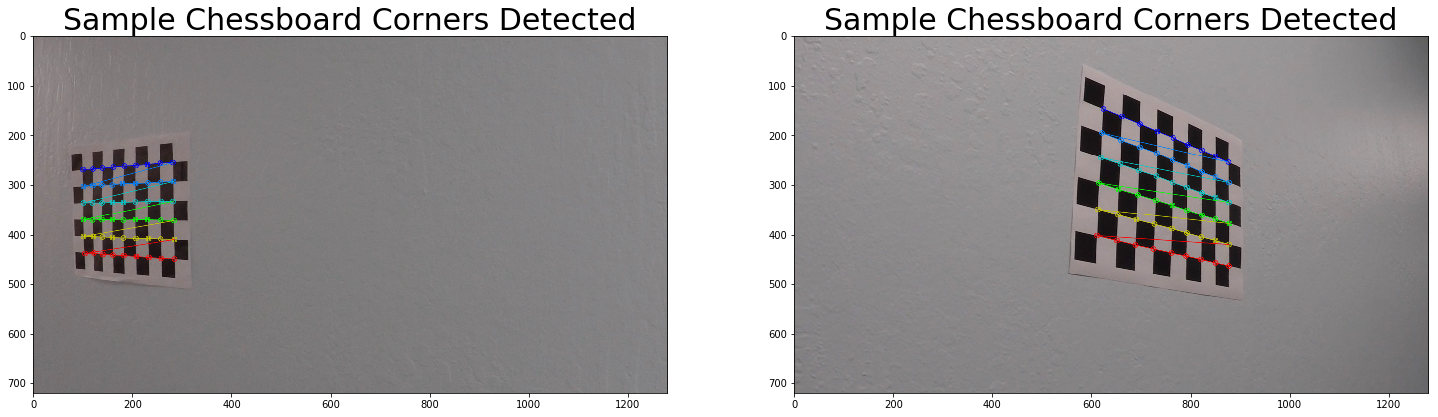

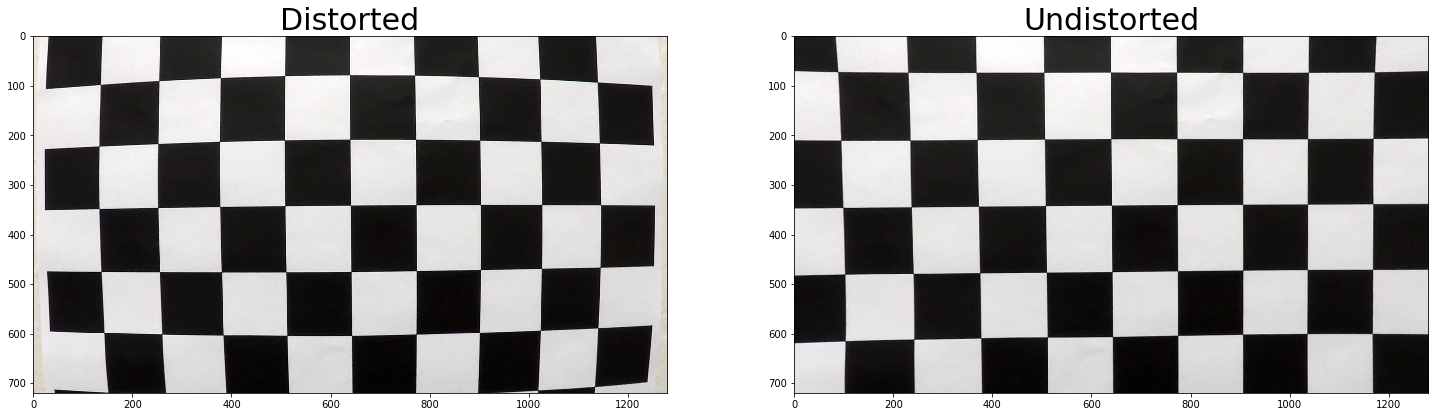

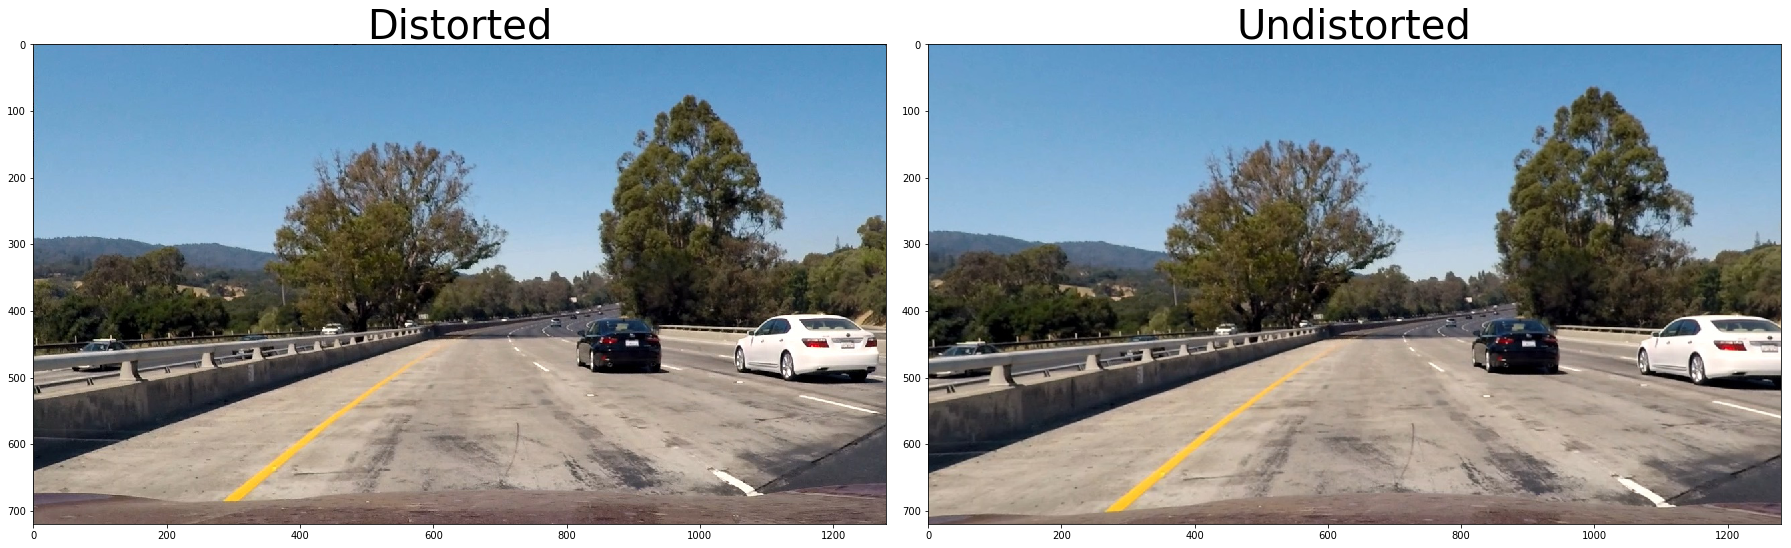

In [4]:
plt.clf()
f,(ax1,ax2)=plt.subplots(1,2,figsize=(25,10))
f,(ax3,ax4)=plt.subplots(1,2,figsize=(25,10))
f,(ax5,ax6)=plt.subplots(1,2,figsize=(25,10))
f.tight_layout()
ax1.imshow(img_list[0])
ax1.set_title("Sample Chessboard Corners Detected", fontsize=30)
ax2.imshow(img_list[1])
ax2.set_title("Sample Chessboard Corners Detected", fontsize=30)
ax3.imshow(undist)
ax3.set_title("Distorted", fontsize=30)
ax4.imshow(original)
ax4.set_title("Undistorted", fontsize=30)
ax5.imshow(dist_img)
ax5.set_title("Distorted", fontsize=40)
ax6.imshow(undist_img)
ax6.set_title("Undistorted", fontsize=40)
plt.show()

### Collection of key image operations

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the Sobel in x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, sobel_kernel)
    
    # Calculate the gradient magnitude 
    gradmag=np.sqrt(sobelx**2 +sobely**2)
    
    # Rescale to 8bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Create a binary image of 1's where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradient 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, None, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, None, sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    abs_grad_dir= np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # Convert RGB to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary_output


### Thresholding Pipeline

In [6]:
def threshold_pipeline(img, s_thresh=(100, 255), l_thresh=(50, 255),dir_thres=(0.8, 1.3), mag_thres=(50,100)):

    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Create similar size array of zeros, For each element in s_channel  >= 100 and <=255 place 1 at similar array location
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Create similar size array of zeros, For each element in l_channel >= 50 and <= 255  place 1 at similar array location
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    #And together elements of l_binary & s_binary
    combined_color = np.zeros_like(s_binary)
    combined_color[((s_binary  == 1) & (l_binary == 1))] = 1

    #Apply Directional threshold, and magnitute threshold
    dir_binary = dir_threshold(img, sobel_kernel=5, thresh=dir_thres)
    mag_binary = mag_thresh(img, sobel_kernel=5, mag_thresh=mag_thres)
    
    # AND results
    combined_mag_dir = np.zeros_like(dir_binary)
    combined_mag_dir[((mag_binary == 1) & (dir_binary == 1))] = 1
    # OR the results of combined_mag_dir and combined_color
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((combined_mag_dir == 1) | (combined_color == 1))] = 1

    return combined_binary


### Plots of the seperate operations along with the output of the thresholding pipeline

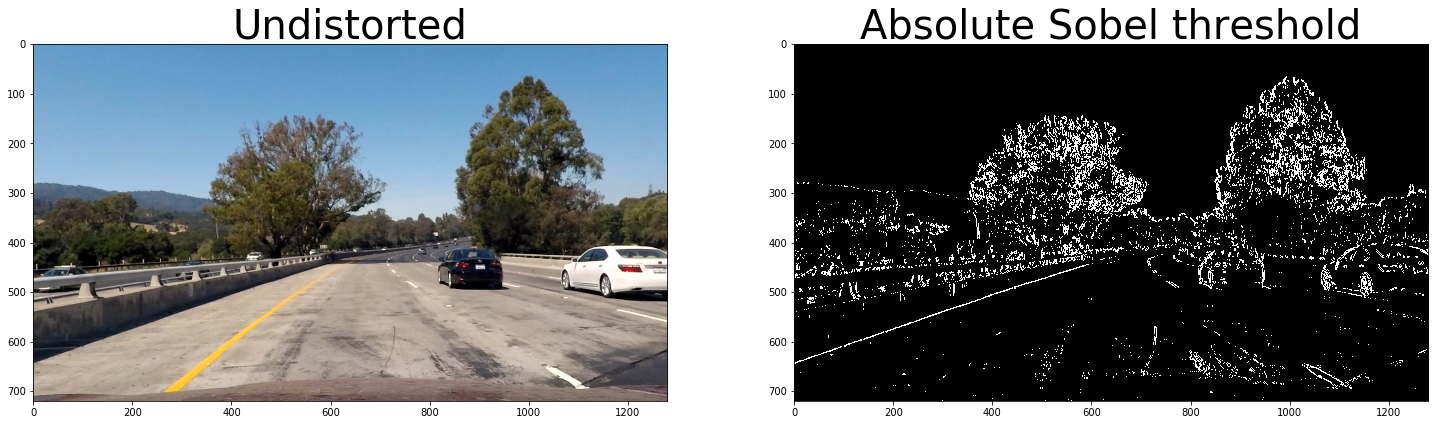

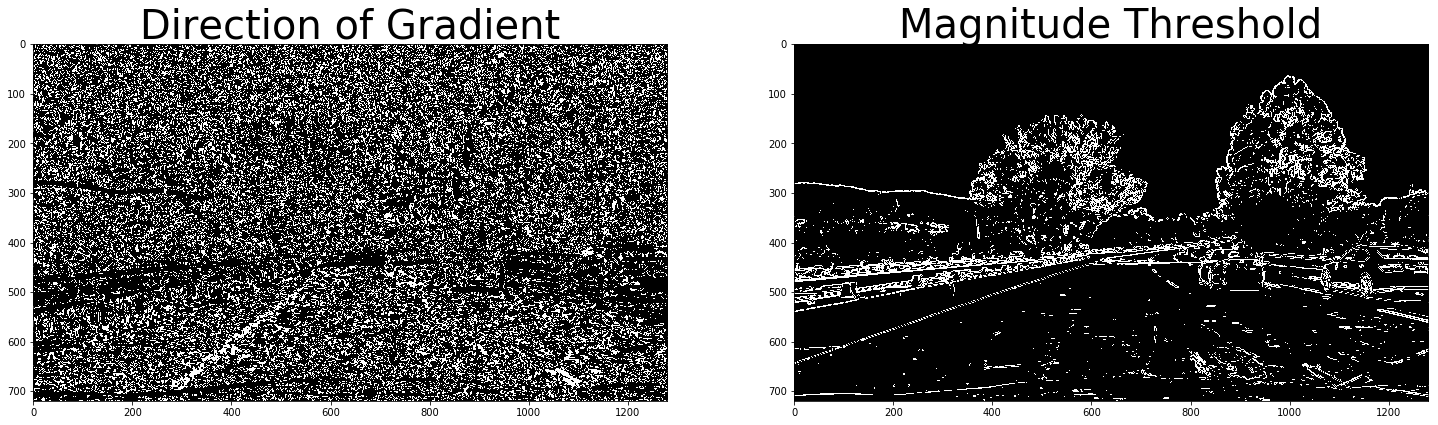

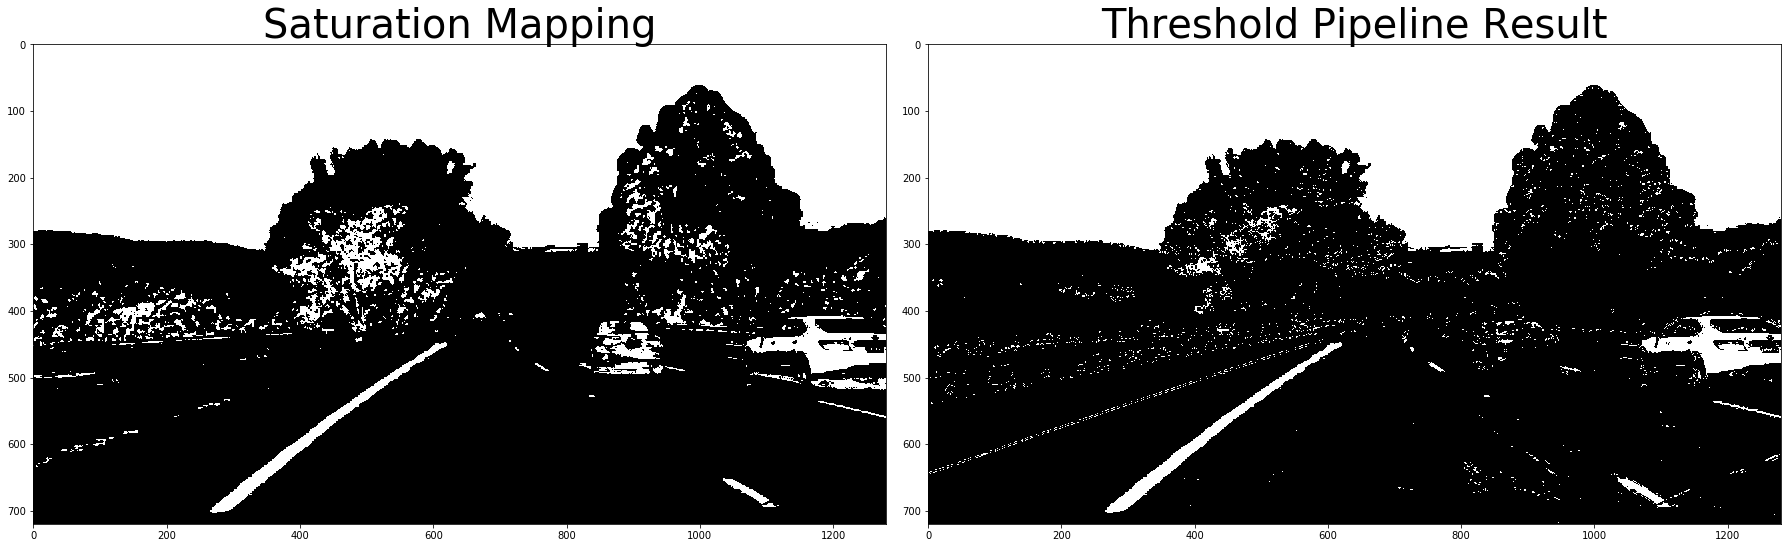

In [7]:
plt.clf()

Thresh_img=threshold_pipeline(undist_img)
abs_sorb_img=abs_sobel_thresh(undist_img,'x',20,100)
img_saturated=hls_select(undist_img,(100,255))
dir_thresh=dir_threshold(undist_img,15,(0.8,1.2))
mag_t_img=mag_thresh(undist_img,3,(30,100))

# Plot the result
f,(ax1,ax2)=plt.subplots(1,2,figsize=(25,10))
f,(ax3,ax4)=plt.subplots(1,2,figsize=(25,10))
f,(ax5,ax6)=plt.subplots(1,2,figsize=(25,10))
f.tight_layout()


ax1.imshow(undist_img)
ax1.set_title("Undistorted", fontsize=40)

ax2.imshow(abs_sorb_img,cmap='gray')
ax2.set_title('Absolute Sobel threshold', fontsize=40)

ax3.imshow(dir_thresh,cmap='gray')
ax3.set_title('Direction of Gradient', fontsize=40)

ax4.imshow(mag_t_img,cmap='gray')
ax4.set_title("Magnitude Threshold", fontsize=40)

ax5.imshow(img_saturated,cmap='gray')
ax5.set_title("Saturation Mapping",fontsize=40)

ax6.imshow(Thresh_img,cmap='gray')
ax6.set_title("Threshold Pipeline Result", fontsize=40)
plt.show()

## Warping function 
### Creates birdseye view of both binary threshed and undistorted image

* Takes an image
* Undistort image
* Apply threshold pipeline to undistorted image, return binary threshold version
* Grab trapezoid region of the image
* Warp the trapezoid region from both undistorted image and binary threshold version
* Return both warped regions along with Perspective inverse value Minv


In [8]:
def warp (img):
    img = np.copy(img)

    img_size = (img.shape[1], img.shape[0])

    #Correct for distortion
    img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

    #Percentage of total image size used to generate corners of points of a trapezoid
    top = 0.075
    bot = 0.425
    side = 0.625

    #Create a thresholded binary image
    threshold_binary = threshold_pipeline(img_corrected);

    ###Perform a perspective transform
  
    src = np.float32([[
        (int((img_size[0]/2)-(bot*img_size[0])),img_size[1]),
        (int((img_size[0]/2)-(top*img_size[0])),int(img_size[1]*side)), 
        (int((img_size[0]/2)+(top*img_size[0])),int(img_size[1]*side)), 
        (int((img_size[0]/2)+(bot*img_size[0])),img_size[1])
        ]])
    
    """ src= 
    [[[ 96.   720.] Points of a trapezoid, see question 3 in writeup
    [  544.   450.]
    [  736.   450.]
    [ 1184.   720.]]]
    """

    # Return points default image size

    dst = np.float32([
        [0, img_size[1]], 
        [0, 0],
        [img_size[0], 0],
        [img_size[0], img_size[1]]
        ])
    """ dst=
    [[    0.   720.] Corners of original image
     [    0.     0.]
     [ 1280.     0.]
     [ 1280.   720.]]
    """
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    #region warped
    warped = cv2.warpPerspective(img_corrected, M, img_size)
    binary_warped = cv2.warpPerspective(threshold_binary, M, img_size)
    
    return binary_warped,Minv,warped

### Main lane detection pipeline


In [9]:
center_array=np.array([]).reshape(0,30)
left_curve_array=np.array([]).reshape(0,30)
right_curve_array=np.array([]).reshape(0,30)


def rolling_mean(array,add):
    array=np.append(array,add)
    if len(array)>60:
        array=np.delete(array,0)
    return np.mean(array)


def pipeline(img, mtx, dist):
    img_corrected = cv2.undistort(img, mtx, dist, None, mtx)

    binary_warped,Minv,warped=warp(img)

    ##Find the Lines
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Identify lane-line pixels and fit their positions with a polynomial
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)


    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)


    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100  

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
     # Generate x and y values for plotting
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    

    #Calculate the radius of curvature of the lane and the position of the vehicle with respect to center
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1047 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    #assuming middle of picture is the center of the car
    mid_pixel = (binary_warped.shape[1]/2)
    
    #Used to draw midpoint line for viewer perspective of warping
    mid_lane = (((right_fitx[719]-left_fitx[719])/2)+ left_fitx[719])
    mid_top_lane=(((right_fitx[0]-left_fitx[0])/2)+ left_fitx[0])

    center_offset = mid_pixel-mid_lane
    offset_meters = (xm_per_pix*center_offset)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #Create moving average for left and right curvature
    left_curverad_mean=rolling_mean(left_curve_array,left_curverad)
    right_curverad_mean=rolling_mean(right_curve_array,right_curverad)
    avg_curverad = int((left_curverad_mean + right_curverad_mean) /2)

    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.line(color_warp,(int(mid_top_lane),0),(int(mid_lane),800),(0,0,255),20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (img_corrected.shape[1], img_corrected.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img_corrected, 1, new_warp, 0.5, 0)

    #Display Curvature on image
    curve_text = ("Radius of Curvature is " +  str(avg_curverad) + "m")
    cv2.putText(result,curve_text,(50, 50 ),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))
    
    #Display offset on image
    center_average=rolling_mean(center_array,offset_meters)
    display_average=round(abs(center_average),3)
    if (center_average > 0):
        offset_text = ("Car is "+str(display_average)+ "m to the right of the center line")
    else:
        offset_text = ("Car is "+str(display_average)+ "m to the left of the center line")
    cv2.putText(result,offset_text,(50, 100),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255))

    #Add in top-down view into the image
    scaled_warped = cv2.resize(warped,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    x_offset=150
    y_offset=150
    # Insert birds eye view below curve and offset text
    result[y_offset:y_offset+scaled_warped.shape[0], x_offset:x_offset+scaled_warped.shape[1]] = scaled_warped
    
    
    #Save plot that contains the binary/black&white version of the topdown with polynomial fit and bounding
    #boxes, then reads in the img for video creeation
    cvt_out = bgr2rgb(out_img.astype(np.uint8))
    plt.plot(left_fitx, ploty)
    plt.plot(right_fitx, ploty)
    plt.xlim(0, 1280)
    plt.xlabel('X-axis @ 3.7/1047 meters per pixel')
    plt.ylim(720, 0)
    plt.ylabel('Y-axis @ 30/720 meters per pixel')
    plt.imshow(cvt_out)
    plt.savefig('output_images/plot.png')
    plt.close()
    #Read in image and pass to return for video 
    img_plot = cv2.imread('output_images/plot.png')

    return result, img_plot


## Create video of birds-eye view after going through image threshold pipeline

In [10]:

def process_graph(image):
    returned_img ,img_graph= pipeline(image, mtx, dist)
    return img_graph

clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)
graph = 'output_images/video_graph.mp4'
clip = clip1.fl_image(process_graph) #NOTE: this function expects color images!!
clip.write_videofile(graph, audio=False)


[MoviePy] >>>> Building video output_images/video_graph.mp4
[MoviePy] Writing video output_images/video_graph.mp4


100%|█████████▉| 1260/1261 [06:33<00:00,  3.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_graph.mp4 



## Create lane detection video

In [11]:

def process_image(image):
    returned_img ,img_graph= pipeline(image, mtx, dist)
    return returned_img

clip1 = VideoFileClip("project_video.mp4")#.subclip(0,6)
output = 'output_images/video_output.mp4'
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video output_images/video_output.mp4
[MoviePy] Writing video output_images/video_output.mp4


100%|█████████▉| 1260/1261 [06:35<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_output.mp4 



### Video of trapezoid region transformed to birds-eye view along with the polynomial fit function applied over lane lines

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(graph))

## Final Video
### Includes the radius of curvature in meters the distance of the car from the middle of the lane and a birds-eye view inserted into the image

* Red Lines highlight lane markers, if you look closely you can see them appear on the white lines on the right of the lane
* Green area is the space between the lines
* Blue line is the calculated center of the lane


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))